# Setup system dynamics
> @author: Jiheng Duan, Pan Shi

## About

This document will tell you how to do system dynamics using `qutip.mesolve`, including setup dynamical term of the Hamiltonian by writing a pulse sequence.

### Required Import

**The following thing must be import.**

In the current folder (despite `~\Tutorial\arb_qubit_tutorial\`), the system structure are based on file `~\System\transmon_system.py`. For using arbitrary qubit system structure, please move to the demonstration file under `~\Tutorial\arb_qubit_tutorial\`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../..')

import QuSim.System.transmon_system as qs
# Some useful tools
import QuSim.Instruments.tools as tools
# Some intrinsic plotting function
import QuSim.DataPlot.plot_lib as pl

# variable name -> string
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

### Optional import

**The following import are optional**

In [3]:
# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

## Mathematical formulism

The dynamics of a defined system is given by formulating its pulse sequence. So the procedure is:

1. Initializing system parameters
2. Determine the simulation option
3. Determine the pulse sequence
4. Plot the pulse sequence to check the correctness
5. Do system dynamics
6. Plot the result.

The system Hamiltonian can be written into to parts:
$$
H = H_0 + H_d (t)
$$
where $H_0$ is the Hamiltonian of system itself and the interactions between subsystems. The driven Hamiltonian can be classified into microwave driving and flux pulse biasing, which provide a XY rotation and bias the qubit frequency, respectively.

* For XY drive, the driving term looks like
$$
H_d (t) = Re\left[A G(t) e^{i\omega t + \phi}\right] i (a - a^\dagger )
$$
where $A \in \mathbb{C}$ is the driven amplitude; $G(t)$ is the envelope, $\omega$ is the carrier frequency, and $\phi$ is the carrier phase. Notice that we assume that the capacitive coupling coefficient between the XY control line and the qubit is reduced to one.

We could also write the drive term as 
$$
\Omega (t) = A G(t) e^{i\omega t + \phi},
$$
And $H_d(t)$ becomes
$$
H_d (t) = Re\left[ \Omega (t) \right] i (a - a^\dagger).
$$

* For Z bias, the driving term looks like
$$
H_d = Re\left[ A G(t) \right] a^\dagger a
$$
The amount of frequency that the system is biased is change of flux on the SQUID for transmon. That means positive $A$ will increase the frequency by an amount of $|A|$, and negative one will decrease the frequency by $-|A|$. 


### Rotating angle
For cosine envelope, the rotating angle $\theta_{ij}$ between two levels with index $i$ and $j$ has the following relation
$$
\frac{\theta_{ij}}{\pi} =  |V_{D, ij}| A t_g
$$
where $A$ the amplitude, $t_g = t_w$ is the `t_width`, and $|V_{D,ij}|$ is the XY drive matrix element of the corresponding two levels.

## Setup system parameters

In [2]:
N = 4 # Maximum excitation level
w = [6.3, 5.85, 6.2] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.3, -0.3, -0.2] # Anharmonicity
r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = tools.r2matrix(r_dic, w) # Coupling strength
gamma_list = None

_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

state_010, E_010, index_010 = _system.get_eigenstates_energy((0,1,0))
state_000, E_000, index_000 = _system.get_eigenstates_energy((0,0,0))
state_001, E_001, index_001 = _system.get_eigenstates_energy((0,0,1))
state_100, E_100, index_100 = _system.get_eigenstates_energy((1,0,0))
state_101, E_101, index_101 = _system.get_eigenstates_energy((1,0,1))

## Simulation option

We care about three parameter here:
1. The Simulation Time: unit in nanosecond
2. Simulation step: steps of simulation
3. Initial state: A list of initial state to allow the program do dynamics from different initial state.

**The simulation step should sufficiently larger than the simulation time in order the have enough samping of the waveform**

Notice that, the key of the dictionary `simulation_option` **should strictly follows the one provided in the example**.

Here, the simulation step should be at least 5 times greater than the simulation time.

Also, the initial state list is a list of ket vector, such as:
`[state_100, state_111, state_101, state_000, ]`

Notice that this simulation can also done by density matrix, just replacing each ket vector by `qs.ket2dm(state_100), ...`

In [3]:
simulation_option = {
    "simulation_time": 400, # Unit in ns
    "simulation_step": 40000,
    "initial_state": [state_000, state_101, state_001] # Do multiple simulation
}
# For density matrix, use qs.ket2dm(state_001)

## Pulse sequence

The pulse sequence is a list, containing multiple single `pulse`, which is a dictionary.

For a pulse sequence `pulse_sequence`, the first pulse is `pulse_sequence[0]`; the 10th pulse is `pulse_sequence[9]`.

For a pulse `pulse`, it contains the following keys and values:

1. `'pulse_index'`: `int`. The index of the pulse. It will not be query in the `PulseGen`. Just for user to know which pulse they are engineering with.
2. `'type'`: `str`. The pulse type of the pulse. It can be `XY` or `Z`.
3. `'pulse_shape'`: `str`. The shape of pulse, the pulse table can be refer to `QuSim.PulseGen.pulse_shape`. We have the following mapping:
```
pulse_shape_dic = {
    'square': square, # Square pulse
    'cosine': cosine, # Cosine
    'hcosine': hcosine, # Half cosine
    'cosh': cosh, # Cosh function with parts greater than zero.
    'tanh': tanh,
    'hyper': hyper # Hyperbolic cosh share, with control parameter \epsilon
}
```

4. `'t_delay'`: `double, float, or int`. Time delay of the raising point of the pulse. Unit in nanosecond
5. `'t_width'`: `double, float, or int`. Width of the pulse. the width of raising and lowering edges equals to half `t_width`, which means `t_rasing = t_lowering = t_width/2`. Unit in nanosecond
6. `'t_plateau'`: `double, float, or int`. The plateau of the pulse. Unit in nanosecond. The length of the pulse equals to `t_plateau + t_width`.
7. `'freq'`: `double, float, or int`. Frequency of the pulse carrier, not angular frequency. Unit in GHz
8. `'phase'`: `double, float, or int`. The phase of the carrier. Unit in rad.
9. `'amplitude'`: `complex`. The pulse amplitude is a complex number. 
10. `'q_index'`: `int`. The index of qubit, starting from `0`.

* Notice that for `'tanh'` and `'hyper'` pulse, we should define an additional key-value in the pulse dictionary. 

11. `epsilon`: `double, float, or int`. The parameter to adjust the shape of the envelope.



In [4]:
pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 20, # unit in ns
        't_width': 80, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_100 - E_000, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': -0.5, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2
    },
    {
        'pulse_index': 2,
        'type': "XY", 
        'pulse_shape': "cosine",
        't_delay': 20,
        't_width': 80,
        't_plateau': 0,
        'freq': E_001 - E_000,
        'pulse_detuning': 0,
        'phase': 0,
        'amplitude': -0.5,
        'q_index': 2
    },
    {
        'pulse_index': 3,
        'type': "Z", 
        'pulse_shape': "tanh",
        't_delay': 150,
        't_width': 100,
        't_plateau': 100,
        'freq': 0,
        'pulse_detuning': 0,
        'phase': 0,
        'amplitude': w[1] - w[0],
        'q_index': 0,
        'epsilon': 2 # Define an additional pulse shape parameter
    },
    {
        'pulse_index': 4,
        'type': "Z",
        'pulse_shape': "hyper",
        't_delay': 150,
        't_width': 100,
        't_plateau': 100,
        'freq': 0,
        'pulse_detuning': 0,
        'phase': 0,
        'amplitude': w[2] - w[0],
        'q_index': 2,
        'epsilon': 2
    }
]

To plot the pulse sequence, we use a build-in function to achieve this feature.

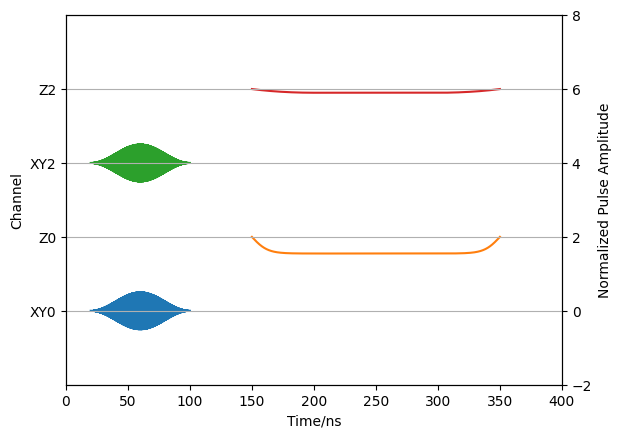

0

In [5]:
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

## Do system dynamics

The system dynamics is done by `qutip.mesolve`. In `QuSim`, the `mesolve` is packaged inside a method of your defined system `system_dynamics_mesolve(simulation_option, pulse_sequence)`. 

After our static system, simulation option, and the pulse sequence is defined, we could use
```
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)
```
to get the simulation result.

The method `system_dynamics_mesolve(simulation_option, pulse_sequence)` returns two variables: `result_list` and `angle_list`, containing simulation results for different initial state provided in `simulation_options['initial_state']` and the phase angle between each intermediate states and their corresponding initial state.

The `result_list` is a nD-list, corresponding to the multiple initial state inside the input. Each element inside the result is a output of the `mesolve`. For instance, is `simulation_options['initial_state'] = [state_000, state_101, state_001]`, then the their corresponding result from `mesolve` is `result_list[0]`, `result_list[1]`, and `result_list[2]`, where `len(result_list) == 3`

In [ ]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

## Plot

As we talked in the last subsection, you could write your own plot based on each result in the `result_list` for different initial states.

Also, I give a build-in plot function to plot a multiple subplots figure. The number of subplots equals to the number of initial state you have.

Inside one single subplot, we could plot the projection of all intermediate state inside the result to any desired quantum states.

$$
|\langle \Psi(t) | \Psi_n(t) \rangle|^2
$$
where $|\Psi(t)\rangle$ is any intermediate state inside the result, and $|\Psi_n(t)\rangle$ is an quantum state you want to project on.

* We first define more state kets.

In [8]:
# Define more states
state_100, _, _ = _system.get_eigenstates_energy((1,0,0))
state_001, _, _ = _system.get_eigenstates_energy((0,0,1))
state_110, _, _ = _system.get_eigenstates_energy((1,1,0))
state_011, _, _ = _system.get_eigenstates_energy((0,1,1))
state_101, _, _ = _system.get_eigenstates_energy((1,0,1))

state_102, _, _ = _system.get_eigenstates_energy((1,0,2))
state_201, _, _ = _system.get_eigenstates_energy((2,0,1))
state_200, _, _ = _system.get_eigenstates_energy((2,0,0))
state_002, _, _ = _system.get_eigenstates_energy((0,0,2))

state_103, _, _ = _system.get_eigenstates_energy((1,0,3))

* Then, we define a 2D-list, contains all the state you want to project on.

For instance, we have three initial state:
```
simulation_options['initial_state'] = [state_000, state_101, state_001]
```
I want to see the project of `state_000` on `state_000`; `state_101` on `state_101` and `state_000`; and `state_001` on `state_102, state_201, state_200, state_002, state_103`. The `interested_state` is given by

```
interested_state = [
                    [state_000],
                    [state_101, state_000],
                    [state_102, state_201, state_200, state_002, state_103]
                    ]
```

Then, we need to conver the variable name to string in order to make legend in the plot. Using the function `var_name2str()`.

In [9]:
# state that you want to plot each simulation
interested_state = [
                    [state_000],
                    [state_101, state_000],
                    [state_102, state_201, state_200, state_002, state_103]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

Then, we could use the build-in plot function `pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)`

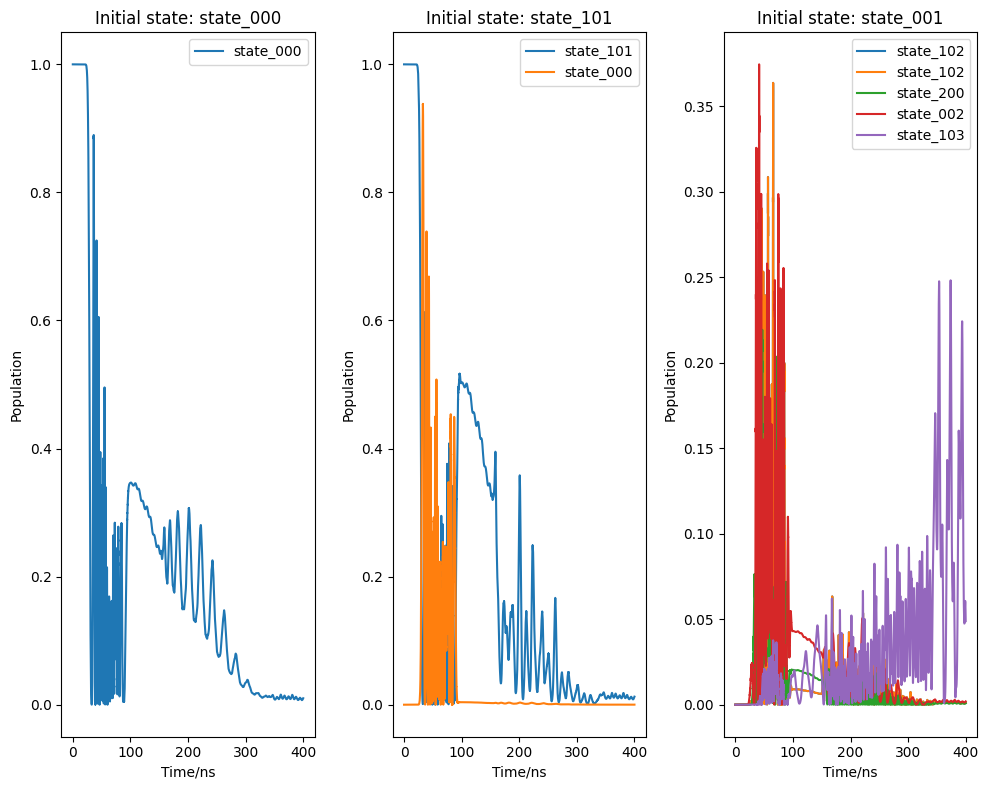

0

In [10]:
%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

## Single Qubit example

In [43]:
N = 3 # Maximum excitation level
w = [6.3] # Qubit frequency
q_dim = [3 for _ in range(len(w))]
alpha =[-0.3] # Anharmonicity

r = 0 # Coupling strength
gamma_list = None

_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))
state_2, E_2, index_2 = _system.get_eigenstates_energy((2,))

simulation_option = {
    "simulation_time": 100, # Unit in ns
    "simulation_step": 10000,
    "initial_state": [state_0, state_1] # Do multiple simulation
}
# For density matrix, use qs.ket2dm(state_001)
pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 20, # unit in ns
        't_width': 18.9, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': -0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2
    }
]

In [44]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

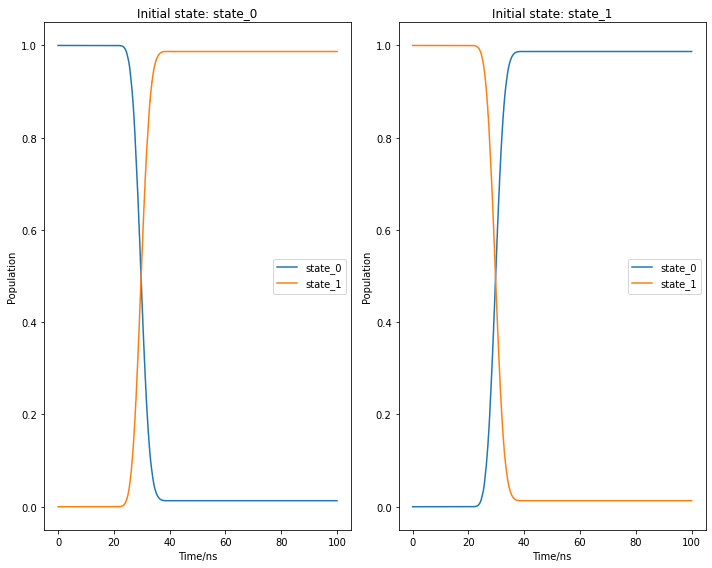

0

In [45]:
# state that you want to plot each simulation
interested_state = [
                    [state_0, state_1],
                    [state_0, state_1]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

## Two qubit example

In [38]:
N = None # Maximum excitation level
w = [6.3, 5.85] # Qubit frequency
q_dim = [2 for _ in range(len(w))]
alpha =[0, 0] # Anharmonicity

r_dic = {
    "r12": 0.05
}
r = tools.r2matrix(r_dic, w) # Coupling strength

r = 0 # Coupling strength
gamma_list = None

_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

state_00, E_00, index_00 = _system.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system.get_eigenstates_energy((1,1))

simulation_option = {
    "simulation_time": 100, # ns
    "simulation_step": 200000,
    "initial_state": [state_00] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 11, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    },
    {
        'pulse_index': 1,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 50, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    },
    {
        'pulse_index': 2,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 79, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    }
]

# pulse_sequence = [
#     {
#         'pulse_index': 0,
#         'type': "XY", # 'XY' or 'Z'
#         'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
#         't_delay': 11, # unit in ns
#         't_width': 20, # unit in ns
#         't_plateau': 0, # unit in ns
#         'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
#         'pulse_detuning': 0,
#         'phase': 0, # unit in rad;
#         'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
#         'q_index': 1 # 0, 1, 2
#     }
# ]


# pl.plot_pulse_sequence(pulse_sequence, simulation_option)


In [9]:
_system.H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.         36.75663405  0.          0.        ]
 [ 0.          0.         39.58406744  0.        ]
 [ 0.          0.          0.         76.34070148]]

In [39]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

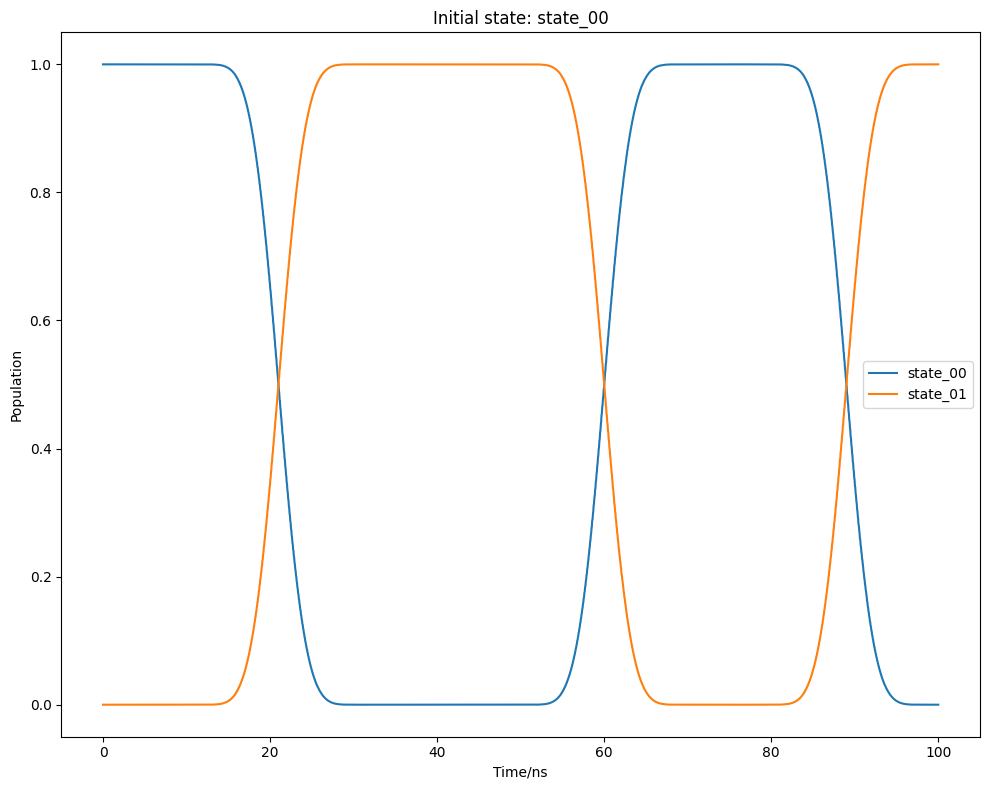

0

In [40]:
# state that you want to plot each simulation
interested_state = [
                    [state_00, state_01]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

## Using density matrix

### Setup system parameter

In [11]:
N = None # Maximum excitation level
w = [6.3, 5.85, 6.2] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.3, -0.3, -0.2] # Anharmonicity
r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = tools.r2matrix(r_dic, w) # Coupling strength

gamma_list = None

_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

# print(_system.co_list()[0])
# Get level spacing between |010> and |000>
# State represented in tuple, e.g., |100> ==> (1,0,0)
state_010, E_010, index_010 = _system.get_eigenstates_energy((0,1,0))
state_000, E_000, index_000 = _system.get_eigenstates_energy((0,0,0))
state_001, E_001, index_001 = _system.get_eigenstates_energy((0,0,1))
state_100, E_100, index_100 = _system.get_eigenstates_energy((1,0,0))


The difference is, we use `qs.ket2dm()` to convert a state ket vector into their corresponding density matrix, in the `simulation_option["initial_state"]`.

In [16]:
simulation_option = {
    "simulation_time": 200, # ns
    "simulation_step": 20000,
    "initial_state": [qs.ket2dm(state_100)] # Do multiple simulation
}
# For density matrix, use qs.ket2dm(state_001)

pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 30, # unit in ns
        't_plateau': 150, # unit in ns
        'freq': E_100 - E_000, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': -0.2, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    }
]

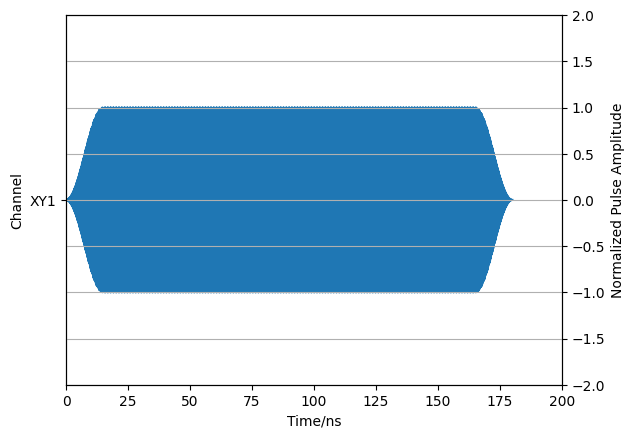

0

In [17]:
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [18]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

### Plot
Here is an example of plot the dynamics done by density matrix. We use the first result in `result_list` which is `result_list[0]`. By take the state out `result.states`, we use `qs.expect()` to get the expectation value of the density matrix.

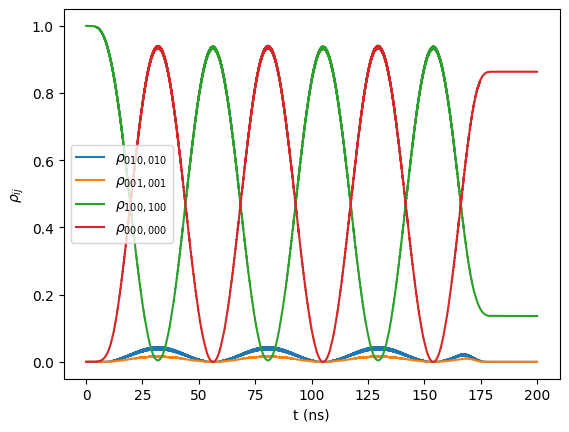

In [19]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

plt.plot(t,qs.expect(result.states, state_010 * qs.dag(state_010)), label=r'$\rho_{010,010}$');
plt.plot(t,qs.expect(result.states, state_001 * qs.dag(state_001)), label=r'$\rho_{001,001}$');
plt.plot(t,qs.expect(result.states, state_100 * qs.dag(state_100)), label=r'$\rho_{100,100}$');
plt.plot(t,qs.expect(result.states, state_000 * qs.dag(state_000)), label=r'$\rho_{000,000}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

## Using propagator

We could also use propagator to calculate the system dynamics. A propagator is defined as
$$
U(t_1, t_2) = \exp(-i\frac{H}{\hbar}(t_2 - t_1)).
$$

Assume the state at $t = t_1$ is $|\Psi(t_1)\rangle$. Then, the state at $t = t_2$ is $|\Psi(t_2)\rangle$ under the evolution of Hamiltonian $H$.

In the code, the propagator is from $t = 0$ to $t$ inside `t = np.linspace(0, simulation_time, simulation_step)`. To get the state at `t[k]`, we should use kth propagator to multiply the initial state to get the state at `t[k]`.

### Setup system parameters

In [7]:
N = None # Maximum excitation level
w = [6.3, 5.85, 6.2] # Qubit frequency
q_dim = [2 for _ in range(len(w))]
alpha =[-0.3, -0.3, -0.2] # Anharmonicity
r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = tools.r2matrix(r_dic, w) # Coupling strength
gamma_list = None

_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)
state_000, E_000 , _ = _system.get_eigenstates_energy((0,0,0))
state_100, E_100 , _ = _system.get_eigenstates_energy((1,0,0))

In [10]:
simulation_option = {
    "simulation_time": 500, # ns
    "simulation_step": 5000,
    "initial_state": [qs.ket2dm(state_100)] # Do multiple simulation
}
# For density matrix, use qs.ket2dm(state_001)

pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 30, # unit in ns
        't_plateau': 150, # unit in ns
        'freq': E_100 - E_000, #E_100 - E_000, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': -0.2, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    }
]

In [11]:
propagator = _system.system_dynamics_propagator(simulation_option, pulse_sequence)

12.5%. Run time:   2.07s. Est. time left: 00:00:00:14
25.0%. Run time:   2.35s. Est. time left: 00:00:00:07
37.5%. Run time:   2.41s. Est. time left: 00:00:00:04
50.0%. Run time:   2.51s. Est. time left: 00:00:00:02
62.5%. Run time:   2.54s. Est. time left: 00:00:00:01
75.0%. Run time:   2.58s. Est. time left: 00:00:00:00
87.5%. Run time:   2.69s. Est. time left: 00:00:00:00
100.0%. Run time:   2.75s. Est. time left: 00:00:00:00
Total run time:   2.76s
